In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()


In [3]:
# index all char 
chars = sorted(list(set(''.join(words)))) # make sorted list for all Alphabet in word dataset.
stoi  = {c:i+1 for i,c in enumerate(chars)} 
# hoin['<S>'] = 26
# choin['<E>'] = 27
stoi['.'] = 0

itos = {i+1:c for i,c in enumerate(chars)} 
# inoch[26] = '<S>'
# inoch[27] = '<E>'
itos[0] = '.'
vocab_size = len(itos) # 27


In [4]:
block_size = 3  
def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
seed = 2147483647 # for reproducibility
g = torch.Generator().manual_seed(seed) 
C  = torch.randn((vocab_size, n_embd),            generator=g)
w1_inti_scaler = (5/3)/((n_embd * block_size)**0.5) # Kaiming init for tanh fan_in
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * w1_inti_scaler  # 0.2
#b1 = torch.randn(n_hidden,                       generator=g) * 0.01 
###
# We now want to need bias term because of batch layer have its own bias who
# can shif Distribution of the data
###
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))  # gamma
bnbias = torch.zeros((1, n_hidden)) # beta
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # Minibatch construct

  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # -------------------------------------------------------------
  # Forward pass

  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # -------------------------------------------------------------
  # BatchNorm layer

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

  # Updating averge Mean and Std (Need for Inferance)
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # -------------------------------------------------------------
  # Non-linearity
    
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2    # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # -------------------------------------------------------------
  # Backward pass

  for p in parameters:
    p.grad = None
  loss.backward()

  # -------------------------------------------------------------
  # Update
  
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


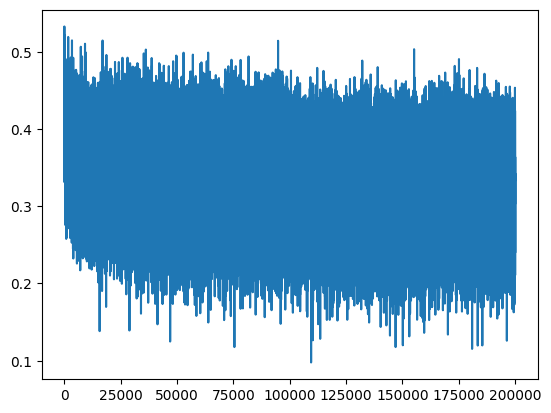

In [9]:
plt.plot(lossi)

### BatchNorm

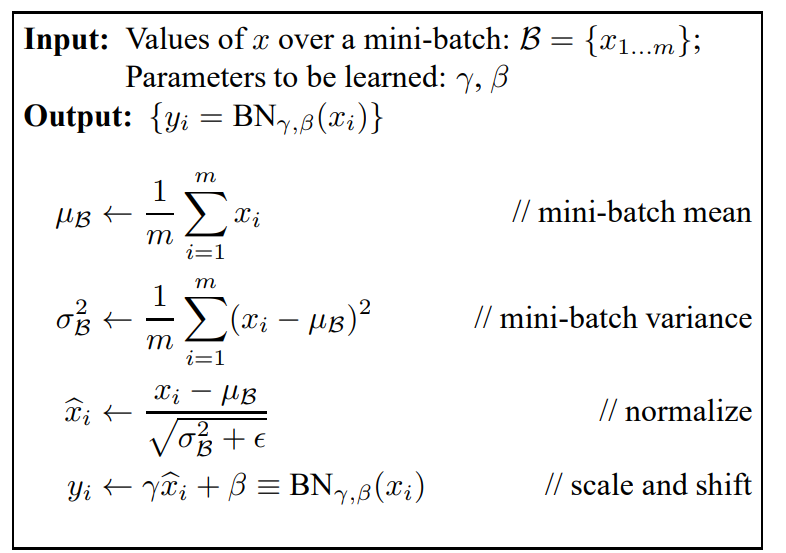


In [10]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [11]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


In [12]:
# Name_start_of = 's'
# while True:
    
#     out = []
#     context = [0] * 2 + [stoi[Name_start_of]]
#     emb =  C[torch.tensor(context)] 
#     embcat = emb.view(1, -1) 
#     hpreact = embcat @ W1 
#     # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#     hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
#     h = torch.tanh(hpreact) 
#     logits = h @ W2 + b2 
#     probs = F.softmax(logits, dim=1)
#     ix = torch.argmax(probs).item()
#     context = context[1:] + [ix]
#     out.append(ix)
#     if ix == 0:
#         break
    
# print(''.join(itos[i] for i in out))

In [13]:
# loss log
#---------------------------------------------------------------#
# original:
# train 2.1245384216308594 val 2.168196439743042
#---------------------------------------------------------------#
# fix softmax confidently wrong:
# train 2.07 val 2.13
#---------------------------------------------------------------#
# fix tanh layer too saturated at init:
# train 2.0355966091156006 val 2.1026785373687744
#---------------------------------------------------------------#


Useful links:

- "Kaiming init" paper: https://arxiv.org/abs/1502.01852
- BatchNorm paper: https://arxiv.org/abs/1502.03167
- Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/b...
- Good paper illustrating some of the problems with batchnorm in practice: https://arxiv.org/abs/2105.07576


In [35]:
from typing import Any


class Linear:
    def __init__(self,fan_in,fan_out,bias=True) -> None:
        self.weights = torch.randn(fan_in,fan_out,generator=g) / ( fan_in ** 0.5)
        self.bias = torch.zeros(fan_out)  if bias else None 
    def __call__(self, x) -> Any:
        self.out = (x @ self.weights)
        if self.bias != None:
            self.out += self.bias
        return self.out
    def paramerters(self)->list:
        return [self.weights] + ([] if self.bias == None else [self.bias]) 
        
class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1) -> None:
        self.training = True # This flag decide to use running buffer or Current batch 
        self.eps = eps
        self.momentum = momentum
        self.dim = dim
        #### Parameters for training ####
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)
        #### Buffer Parameters for inferance ####
        self.running_var  = torch.ones(dim) # ones -> * 
        self.running_mean = torch.zeros(dim) # zeros -> - 
        
    def __call__(self,x: torch.tensor) -> Any:
        '''
        param X -> Batch
        '''
        if self.training:
            # stat data of the batch
            xmean = x.mean(0,keepdim=True)
            xvar  = x.var(0,keepdim=True)
        else:
            xmean =  self.running_mean
            xvar  =  self.running_var  
        xhat = (x - xmean / torch.sqrt(xvar + self.eps))
        self.out = self.gamma * xhat+ self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = ((1 - self.momentum) * self.running_mean) + ((self.momentum) * xmean)
                self.running_var =  ((1 - self.momentum) * self.running_var)  + ((self.momentum) * xvar )
        return self.out        


    def paramerters(self)->list:
        return [self.beta,self.gamma]

class Tanh:
    def __call__(self, x) -> Any:
         self.out = torch.tanh(x)
         return self.out
    def paramerters(self)->list:
        return []
    


In [51]:
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(seed)    
C = torch.randn((vocab_size,n_embd),generator=g)

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weights *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= 5/3

parameters = [C] 
for li in [layer.paramerters() for layer in layers]:
 parameters.extend(li)

print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True      



46497


In [53]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  #-------------------------------------------------------------------
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  #-------------------------------------------------------------------
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x) # Feedward layer by layer
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  #-------------------------------------------------------------------
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #-------------------------------------------------------------------
  lr = 1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #-------------------------------------------------------------------  
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.1533


layer 1 (Tanh): mean -0.02, std 0.77, saturated: 20.50%
layer 3 (Tanh): mean +0.07, std 0.72, saturated: 13.19%
layer 5 (Tanh): mean +0.06, std 0.73, saturated: 11.91%
layer 7 (Tanh): mean +0.07, std 0.72, saturated: 10.06%
layer 9 (Tanh): mean -0.02, std 0.72, saturated: 9.94%


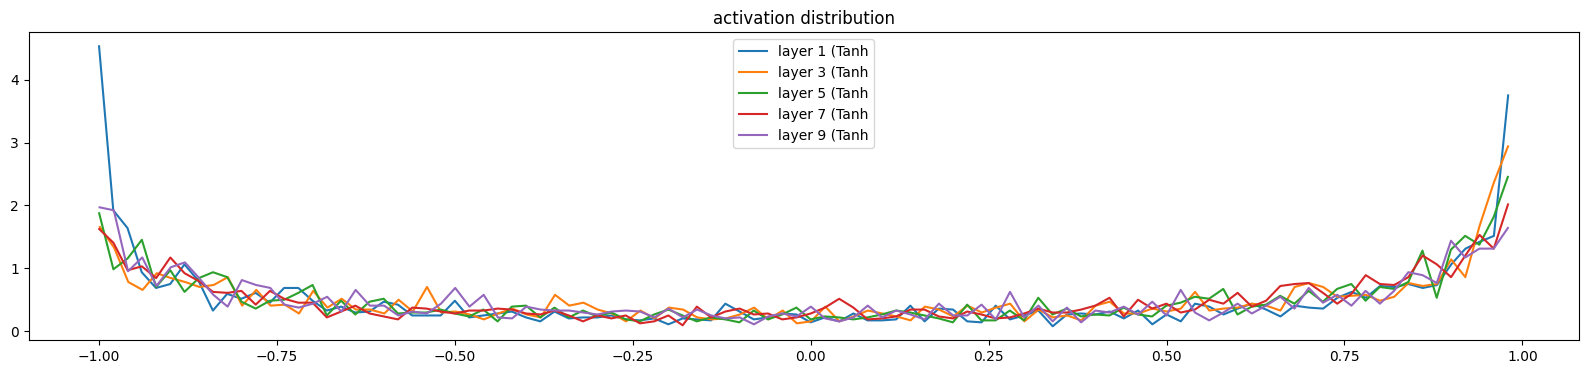

In [46]:
# visualize histograms
### Statistics of weights after Activation without batchNorm ###
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out # Output after activation. 
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');
plt.show()

layer 1 (Tanh): mean +0.000092, std 3.271432e-03
layer 3 (Tanh): mean +0.000112, std 3.158952e-03
layer 5 (Tanh): mean +0.000028, std 2.974314e-03
layer 7 (Tanh): mean +0.000012, std 2.610287e-03
layer 9 (Tanh): mean +0.000011, std 2.295310e-03


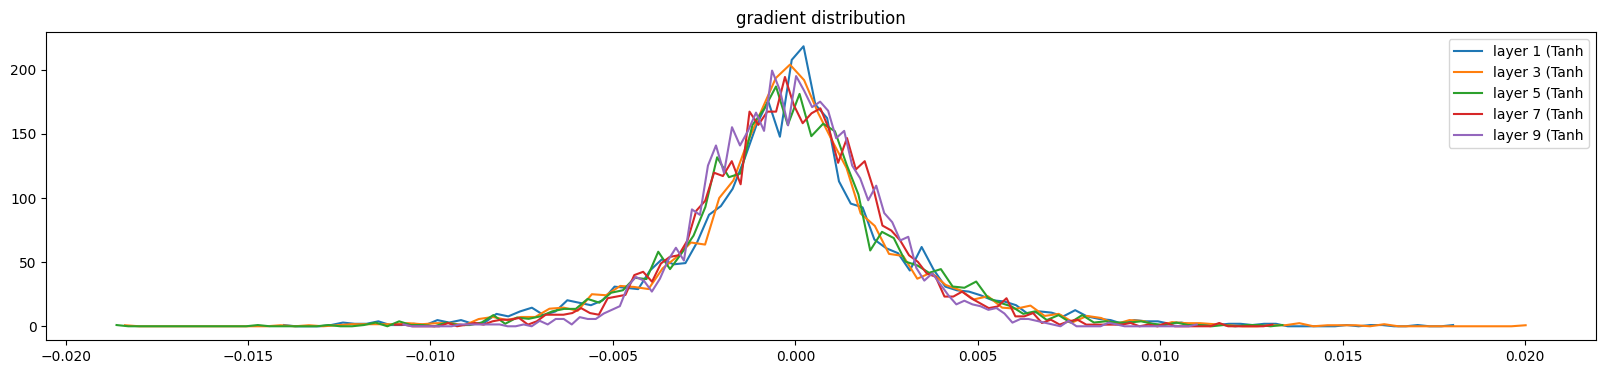

In [47]:
# visualize histograms
### Statistics of gradient without batchNorm ###
# Note: This plot looks good because of Gradient not exploding andd not vanishing.
###############################################################################
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')
plt.show()

In [48]:
# IF we use high gain (5)
# Note: Saturation is very high and this is bad Because there are be no gradient
############################################################################################################
# visualize histograms
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
#   if isinstance(layer, Tanh):
#     t = layer.out
#     print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
#     hy, hx = torch.histogram(t, density=True)
#     plt.plot(hx[:-1].detach(), hy.detach())
#     legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('activation distribution')

* layer 1 (Tanh): mean -0.05, std 0.92, saturated: 68.44%
* layer 3 (Tanh): mean +0.01, std 0.93, saturated: 67.88%
* layer 5 (Tanh): mean +0.02, std 0.93, saturated: 69.12%
* layer 7 (Tanh): mean +0.00, std 0.93, saturated: 69.59%
* layer 9 (Tanh): mean -0.01, std 0.92, saturated: 66.59%

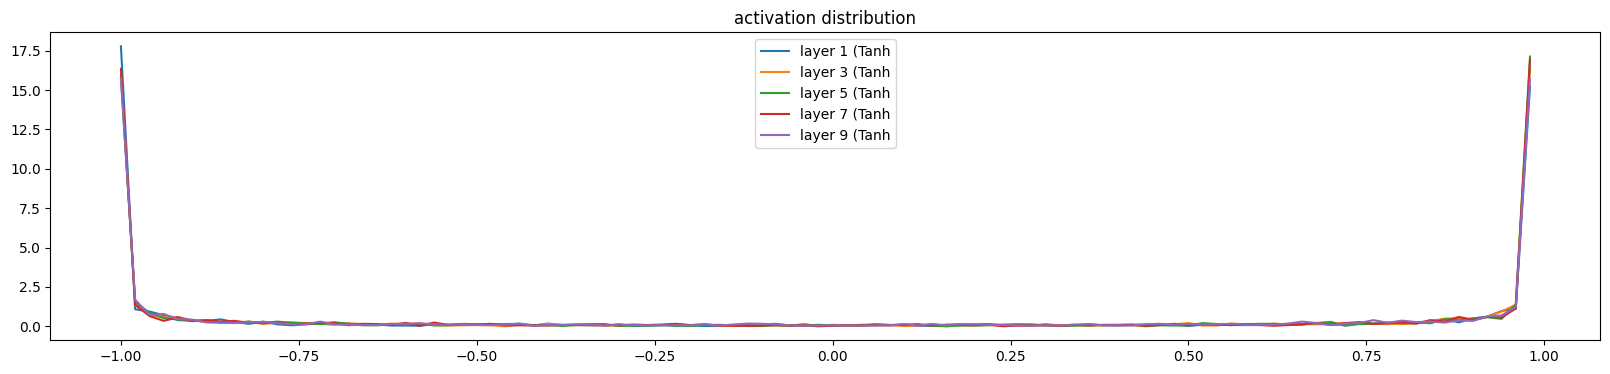

weight   (27, 10) | mean +0.000227 | std 1.201496e-02 | grad:data ratio 1.198896e-02
weight  (30, 100) | mean -0.000017 | std 9.476493e-03 | grad:data ratio 3.046922e-02
weight (100, 100) | mean +0.000076 | std 7.493749e-03 | grad:data ratio 4.419100e-02
weight (100, 100) | mean +0.000115 | std 6.422539e-03 | grad:data ratio 3.808634e-02
weight (100, 100) | mean +0.000049 | std 5.490496e-03 | grad:data ratio 3.260114e-02
weight (100, 100) | mean +0.000025 | std 4.138877e-03 | grad:data ratio 2.455395e-02
weight  (100, 27) | mean +0.000000 | std 1.905170e-02 | grad:data ratio 2.759485e-01


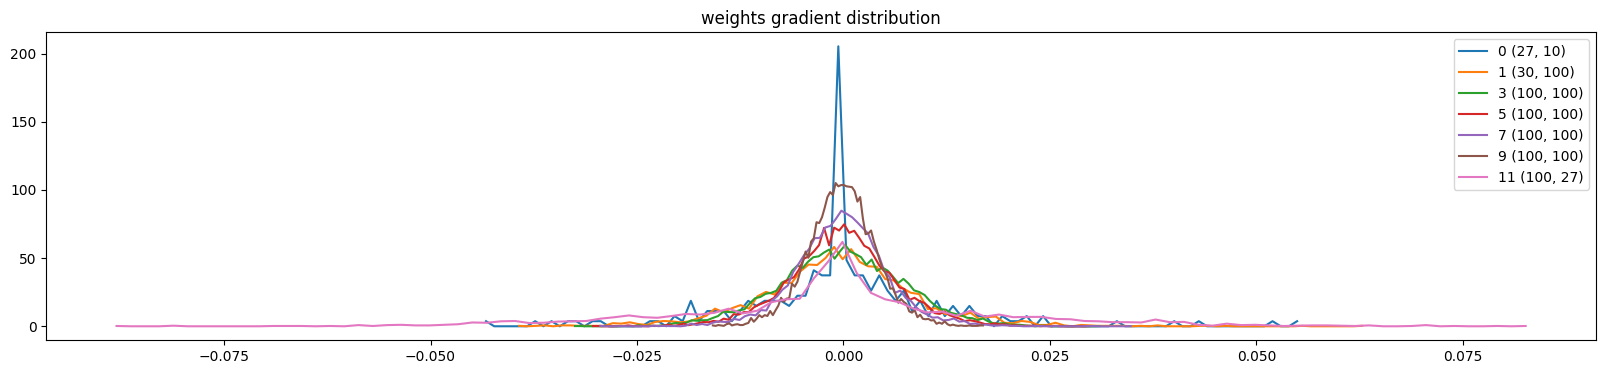

In [49]:
# visualize histograms
### Statistics of wights gradient vs wights it self without batchNorm ###
##########################################################################
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

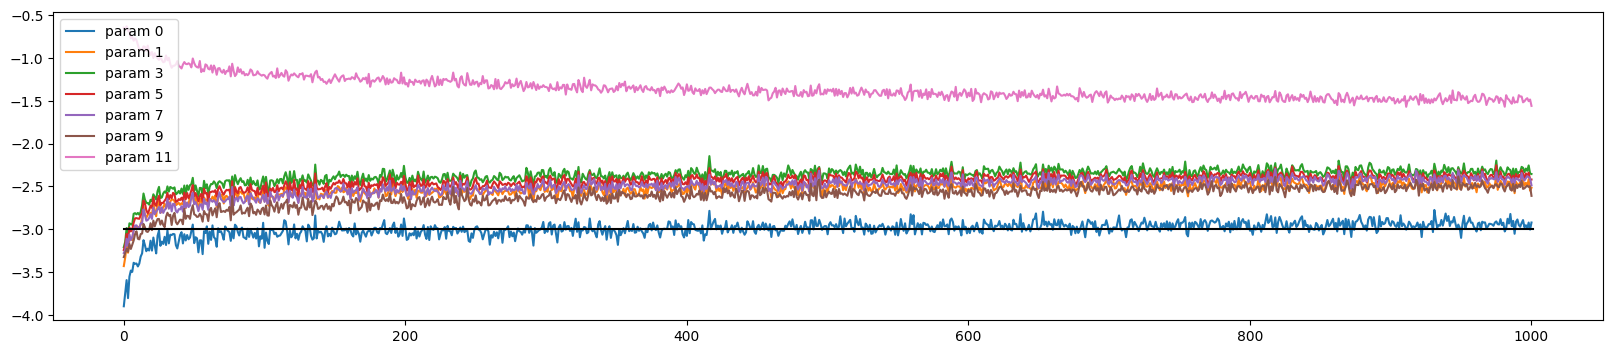

In [50]:
# visualize histograms
### Statistics of parameter update rate without batchNorm ###
# Note: The param 11 update faster then other Because of We squashed the last layer (layers[-1].weights *= 0.1).
################################################################################################################
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [55]:
# # visualize histograms
# ### Statistics of parameter update rate without batchNorm (if we try Higher learning rate) ###
# # Note: All parameters learning crazy rate.
# ################################################################################################################
# plt.figure(figsize=(20, 4))
# legends = []
# for i,p in enumerate(parameters):
#   if p.ndim == 2:
#     plt.plot([ud[j][i] for j in range(len(ud))])
#     legends.append('param %d' % i)
# plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
# plt.legend(legends)

: 

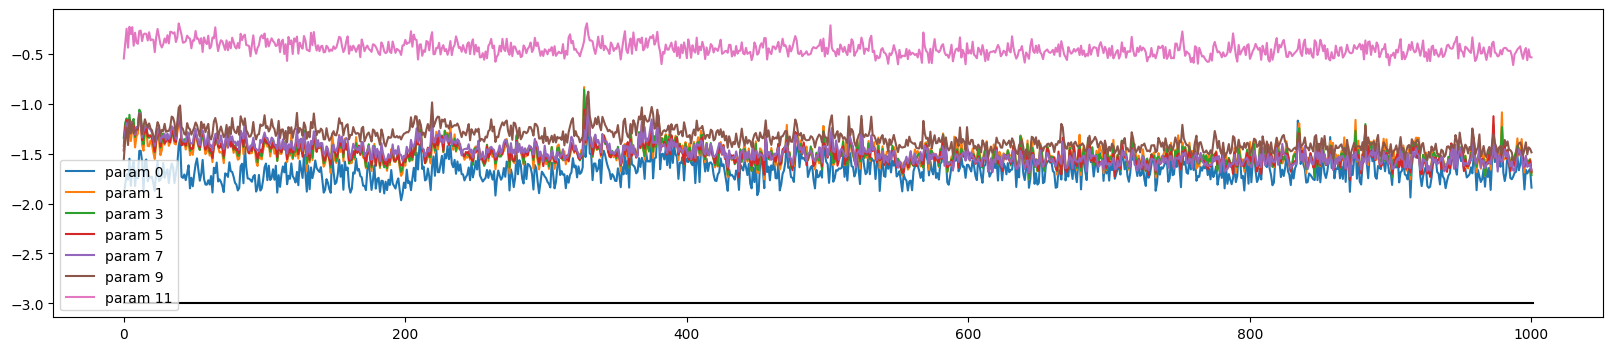